# Initial tests of various models for action classification, motion predictino

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import cv2
import yaml
import os
import glob
import pickle as pkl
import sys
import importlib

In [3]:
# load yaml configuration file w/ keypoints dict ()
# assumes ..\ is root of project
# e.g. C:\MLprojects\motion_analysis\configs\config_analysis.yaml

# set up paths
ROOT_DIR = r"c:\MLprojects\motion_analysis"
CONFIG_DIR = "configs"

def load_config(config_name):
    with open(os.path.join(ROOT_DIR, CONFIG_DIR, config_name)) as file:
        config = yaml.full_load(file)
    return config

CONFIG_KEYPOINTS = load_config(r"keypoints.yaml")
CONFIG_EDGE_COLORS = load_config(r"edge_colors.yaml")
PARAMS = load_config(r"analysis_parameters.yaml")

# Confidence score to determine whether a keypoint prediction is reliable, e.g. for cropping algorithm during inference
KEYPOINT_THRESH_SCORE_CROP = load_config('analysis_parameters.yaml')['KEYPOINT_THRESH_SCORE_CROP']


In [4]:
os.chdir(ROOT_DIR)

In [5]:
# custom modules
from src.io import iomod
from src.inference import inference
from src.visualization import draw
from src.analysis import analysisphysics
from src.tests import testdraw, structshape

# Import plotting libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection # likely limited to draw module
import matplotlib.patches as patches
import seaborn as sns

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display, Image

notes:

In [6]:
'''
loads into dictionaries of keypoints and edges mappings, e.g.:

CONFIG_KEYPOINTS = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

CONFIG_EDGE_COLORS is an ordered dictionary of edge pairs and colors, e.g.:
OrderedDict([((0, 1), 'm'),
             ((0, 2), 'c'),
             ((0, 5), 'm'),
             ((0, 6), 'c'),
             ((1, 3), 'm'),
             ((2, 4), 'c'),
             ((5, 6), 'y'),
             ((5, 7), 'm'),
             ((5, 11), 'm'),
             ((6, 8), 'c'),
             ((6, 12), 'c'),
             ((7, 9), 'm'),
             ((8, 10), 'c'),
             ((11, 12), 'y'),
             ((11, 13), 'm'),
             ((12, 14), 'c'),
             ((13, 15), 'm'),
             ((14, 16), 'c')])

# use e.g. list(CONFIG_EDGE_COLORS).index((2,4)) to get index of edge color

'''
;

''

# checkpoint to start from loaded files

In [7]:
import fnmatch

# load all
with open(r"data\compiled\df_kpts", 'rb') as f:
  df_kpts = pkl.load(f)
with open(r"data\compiled\edge_vel_all", 'rb') as f:
  edge_vel_all = pkl.load(f)
with open(r"data\compiled\edge_length_all", 'rb') as f:
  edge_length_all = pkl.load(f)

infinityds_mp4paths = glob.glob("data\**\*.mp4", recursive=True)
armidx = [path for path in infinityds_mp4paths if "arm" in path]
curlidx = [path for path in infinityds_mp4paths if "curl" in path]

# concatenate all the paths
infinityds_mp4paths_armmotion = armidx + curlidx
infinityds_mp4paths_armmotion

# remove for now jitter or bilateral swapping or other poor quality issues (visualized with x-y plots below)
remove_pattern = ["*armraise*000004.mp4", "*armraise*000005.mp4", "*armraise*000006.mp4", "*armraise*000009.mp4", "*armraise*000013.mp4", "*armraise*000018.mp4", \
  "*armraise*000019.mp4", "*armraise*000033.mp4", "*armraise*000039.mp4", "*armraise*000042.mp4", "*armraise*000044.mp4", "*armraise*000066.mp4", "*armraise*000076.mp4", "*armraise*000094.mp4", "*armraise*000097.mp4", "*armraise*000099.mp4",
  "*armraise*000025.mp4", "*armraise*000044.mp4", "*armraise*000035.mp4", "*armraise*000026.mp4", "*armraise*000020.mp4", \
  "*curl*000001.mp4", "*curl*000022.mp4", "*curl*000025.mp4", "*curl*000034.mp4", "*curl*000035.mp4", "*curl*000043.mp4", "*curl*000049.mp4", \
  "*curl*000053.mp4", "*curl*000056.mp4", "*curl*000057.mp4", "*curl*000060.mp4", "*curl*000061.mp4", "*curl*000068.mp4", "*curl*000080.mp4", \
  "*curl*000080.mp4", "*curl*000082.mp4", "*curl*000090.mp4",]

# remove from list
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion \
  if not any(fnmatch.fnmatch(path, r) for r in remove_pattern)]

data_all, skippct, skippedpaths = iomod.compile_data_wrapper(infinityds_mp4paths_armmotion_rmv)

# remove skipped paths from infinityds_mp4paths_armmotion
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion_rmv if path not in skippedpaths]

FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000092.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000093.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000094.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000095.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000096.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000097.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000098.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000099.mp4


# test out a couple classifiers for action recognition on images

In [8]:
edge_idx = 0
# list(CONFIG_KEYPOINTS)[edge_tuple[0]]
edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
print(f"{edge_tuple=}", structshape.getshape(edge_tuple))
kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
print(f"{kpt1_name=}", structshape.getshape(kpt1_name))
kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
print(f"{kpt2_name=}", structshape.getshape(kpt2_name))

edge_tuple=(0, 1) tuple of 2 int
kpt1_name='nose' str
kpt2_name='left_eye' str


In [9]:
# loop over all out_edges and compute pdist of each edge
edge_length_all = {}
edge_names = []
num_edges = 18

# map edge connectivity keys onto keypoint names for display
for edge_idx in range(num_edges):
  edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
  kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
  kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
  name = f"{kpt1_name}-{kpt2_name}"
  edge_names.append(name)


In [10]:
edge_names

['nose-left_eye',
 'nose-right_eye',
 'nose-left_shoulder',
 'nose-right_shoulder',
 'left_eye-left_ear',
 'right_eye-right_ear',
 'left_shoulder-right_shoulder',
 'left_shoulder-left_elbow',
 'left_shoulder-left_hip',
 'right_shoulder-right_elbow',
 'right_shoulder-right_hip',
 'left_elbow-left_wrist',
 'right_elbow-right_wrist',
 'left_hip-right_hip',
 'left_hip-left_knee',
 'right_hip-right_knee',
 'left_knee-left_ankle',
 'right_knee-right_ankle']

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import itertools
from itertools import product

train_paths, test_paths = train_test_split(infinityds_mp4paths_armmotion_rmv, test_size=0.2)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

list_xy = ["start_x","start_y", "end_x", "end_y"]
name_combinations = []
 
for e1,e2 in product(edge_names, list_xy):
    name_combinations.append(e1 + "-" + e2)

df_edge_features = pd.DataFrame(columns=["path"]+name_combinations)

# limit analysis
analyze_idx = list(range(len(train_paths)))
train_paths = [val for idx, val in enumerate(train_paths) if idx in analyze_idx]

# create features df over paths
for path in train_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features = pd.concat([df_edge_features, df_merged])

df_edge_features.reset_index(drop=True, inplace=True)
df_edge_features

,path,nose-left_eye-start_x,nose-left_eye-start_y,nose-left_eye-end_x,nose-left_eye-end_y,nose-right_eye-start_x,nose-right_eye-start_y,nose-right_eye-end_x,nose-right_eye-end_y,nose-left_shoulder-start_x,...,right_hip-right_knee-end_x,right_hip-right_knee-end_y,left_knee-left_ankle-start_x,left_knee-left_ankle-start_y,left_knee-left_ankle-end_x,left_knee-left_ankle-end_y,right_knee-right_ankle-start_x,right_knee-right_ankle-start_y,right_knee-right_ankle-end_x,right_knee-right_ankle-end_y
0,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,74.976906,80.909683,77.851601,77.387009,74.976906,80.909683,72.188988,77.773384,74.976906,...,70.89756,178.614792,86.2285,179.407852,94.755745,212.284897,70.89756,178.614792,64.977776,210.258545
1,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,75.490143,80.603622,77.807053,76.472908,75.490143,80.603622,71.75592,77.37603,75.490143,...,71.19352,177.881729,85.819717,178.627609,93.936829,211.620544,71.19352,177.881729,65.126152,209.974304
2,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,71.706192,76.429039,73.95253,73.531898,71.706192,76.429039,68.760368,73.385963,71.706192,...,71.173653,177.691681,85.607193,177.726425,94.477493,212.928833,71.173653,177.691681,64.903961,210.499741
3,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,74.572273,78.302147,76.86171,75.153511,74.572273,78.302147,70.948669,75.291679,74.572273,...,70.950981,177.257614,85.768143,178.314957,95.144089,212.48555,70.950981,177.257614,65.139435,210.42868
4,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,74.056526,80.072342,77.126671,76.494507,74.056526,80.072342,71.047676,76.457001,74.056526,...,70.911156,178.062454,85.658356,178.126328,94.895546,214.235413,70.911156,178.062454,65.082031,210.730942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39718,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,96.801704,81.7136,99.462967,79.348862,96.801704,81.7136,94.524467,79.197578,96.801704,...,91.232712,174.202133,105.722504,174.707611,111.744781,208.868423,91.232712,174.202133,87.203003,204.149063
39719,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,94.96006,80.81176,97.770912,78.185326,94.96006,80.81176,92.929146,78.150841,94.96006,...,91.466278,175.28241,105.507797,175.833282,111.876129,209.403931,91.466278,175.28241,87.275871,204.24408
39720,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,95.141541,82.362427,97.571541,79.969772,95.141541,82.362427,92.682571,79.876976,95.141541,...,91.287918,175.061249,105.539879,175.558319,111.776199,208.931259,91.287918,175.061249,87.216003,204.404617
39721,data\infinity\InfinityAI_InfiniteRep_curl_v1.0...,94.185936,81.988884,97.020439,79.675156,94.185936,81.988884,92.262535,79.323944,94.185936,...,90.267921,175.209396,105.281021,175.37796,111.766296,208.669403,90.267921,175.209396,86.962715,203.56073


In [12]:
# find curl or arm raise and extract as labels
labels = []
for path in train_paths:
  for fri in range(data_all["out_edges"][path].shape[0]):
    if "armraise" in path:
      labels.append(0)
    elif "curl" in path:
      labels.append(1)
    else:
      labels.append(None)

In [13]:
# column selector
selector = ColumnTransformer([('path', 'passthrough', name_combinations)])

In [13]:
pipe = Pipeline([('selector', selector), 
                ('LogisticRegression', LogisticRegression(max_iter=10000))])

In [14]:
pipe.fit(df_edge_features, labels)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('path', 'passthrough',
                                                  ['nose-left_eye-start_x',
                                                   'nose-left_eye-start_y',
                                                   'nose-left_eye-end_x',
                                                   'nose-left_eye-end_y',
                                                   'nose-right_eye-start_x',
                                                   'nose-right_eye-start_y',
                                                   'nose-right_eye-end_x',
                                                   'nose-right_eye-end_y',
                                                   'nose-left_shoulder-start_x',
                                                   'nose-left_shoulder-start_y',
                                                   'nose-left_shoulder-e...
                                                   'right_eye-right_ear-start_y',
                                                   'right_eye-right_ear-end_x',
                                                   'right_eye-right_ear-end_y',
                                                   'left_shoulder-right_shoulder-start_x',
                                                   'left_shoulder-right_shoulder-start_y',
                                                   'left_shoulder-right_shoulder-end_x',
                                                   'left_shoulder-right_shoulder-end_y',
                                                   'left_shoulder-left_elbow-start_x',
                                                   'left_shoulder-left_elbow-start_y', ...])])),
                ('LogisticRegression', LogisticRegression(max_iter=10000))])

In [14]:
# create features df over test paths
df_edge_features_test = pd.DataFrame(columns=["path"]+name_combinations)

for path in test_paths:
  # flatten to 2-D with combinations of edge-pair-xy features as above
  data = data_all["out_edges"][path][:, :, :, :].reshape(-1, 72).astype('float32')
  df = pd.DataFrame(data, columns=name_combinations)

  # left merge with path
  df_path = pd.DataFrame(index=np.arange(len(df)), columns=['path'])
  df_path = df_path.assign(path=path)
  df_merged = pd.merge(df_path, df, left_index=True, right_index=True)

  # vertcat
  df_edge_features_test = pd.concat([df_edge_features_test, df_merged])

df_edge_features_test.reset_index(drop=True, inplace=True)


# find curl or arm raise and extract as labels
labels_test = []
for path in test_paths:
  for fri in range(data_all["out_edges"][path].shape[0]):
    if "armraise" in path:
      labels_test.append(0)
    elif "curl" in path:
      labels_test.append(1)
    else:
      labels_test.append(None)


In [16]:
predictions = pipe.predict(df_edge_features_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions))
cm = confusion_matrix(labels, predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)


ValueError: Found input variables with inconsistent numbers of samples: [37591, 12635]

In [ ]:
pipe = Pipeline([('selector', selector), # why doesn't need ()?
                ('GradientBoostingClassifier', GradientBoostingClassifier())])

In [ ]:
# get pipe parameters
pipe.get_params()

In [ ]:
params = [{"GradientBoostingClassifier__max_depth": [3, 6, 9]}]
grid_search = GridSearchCV(pipe, params, cv=5)
# grid_search.fit(linear_residuals.reshape(-1, 1), labels)
grid_search.fit(df_edge_features, labels)

In [ ]:
# get grid search results
grid_search.best_params_, grid_search.best_score_

In [ ]:
# get results
grid_search.cv_results_

In [ ]:
# predict using best params
pipe.set_params(**grid_search.best_params_)
pipe.fit(df_edge_features_test, labels)
test = pipe.predict(df_edge_features_test)

# plot metrics
print(classification_report(labels, predictions))
cm = confusion_matrix(labels, predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(cm)

In [ ]:
params = [{"LogisticRegression__C": [0.1, 1.0, 10.0], 'LogisticRegression__max_iter': [100, 1000, 10000]}]
grid_search = GridSearchCV(pipe, params, cv=5)
# grid_search.fit(linear_residuals.reshape(-1, 1), labels)
grid_search.fit(df_edge_features, labels)

In [ ]:
params = [{"n_estimators": [30, 40, 50, 60], "max_depth": [30, 40], "min_samples_leaf": [10, 15, 20, 25]}]
grid_search = GridSearchCV(model_randomforest, params, scoring="neg_mean_squared_error", cv=5)
grid_search.fit(linear_residuals.reshape(-1, 1), star_ratings)

plot peak normalized x-y coordinates of relevant upper torso keypoints

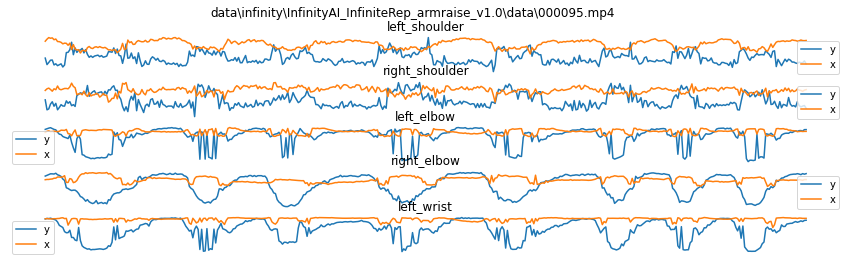

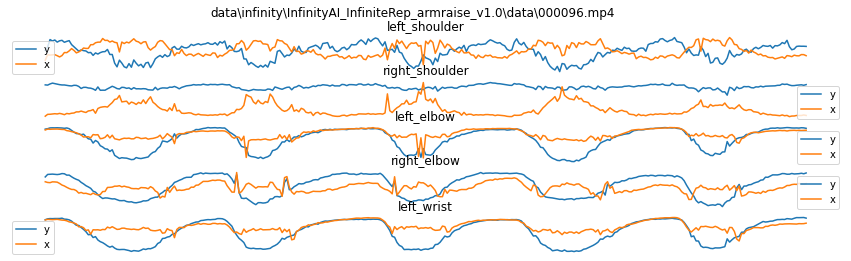

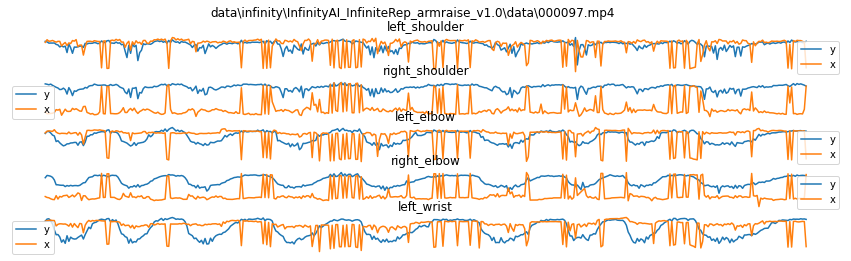

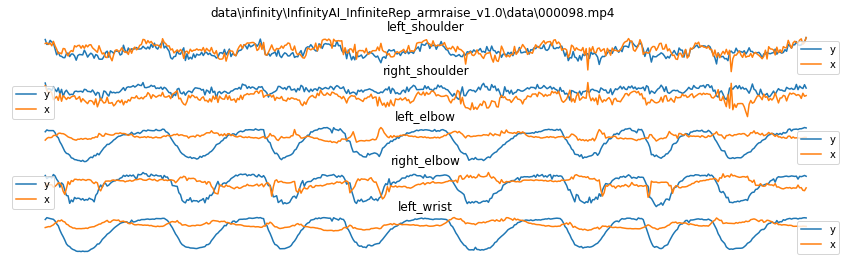

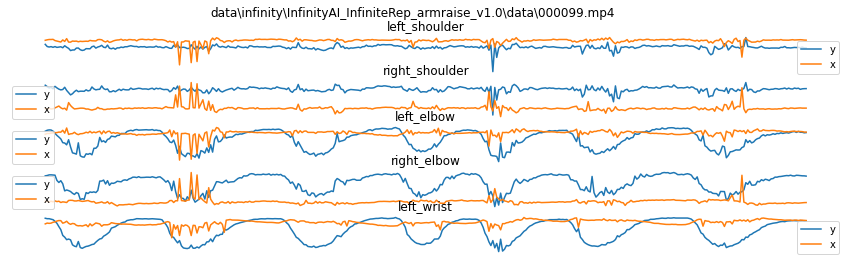

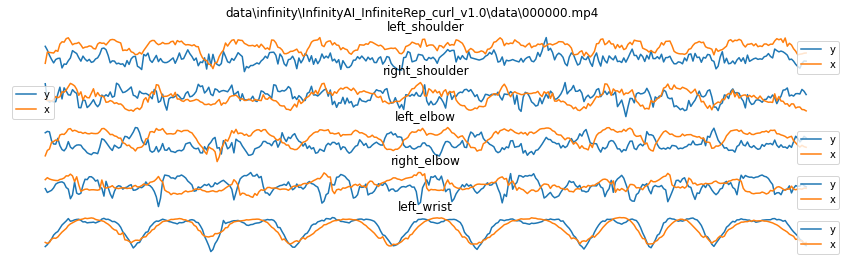

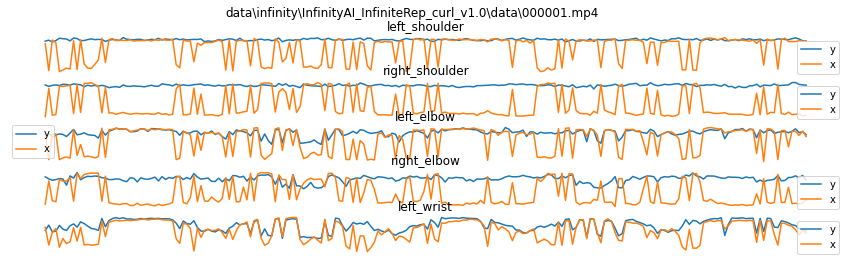

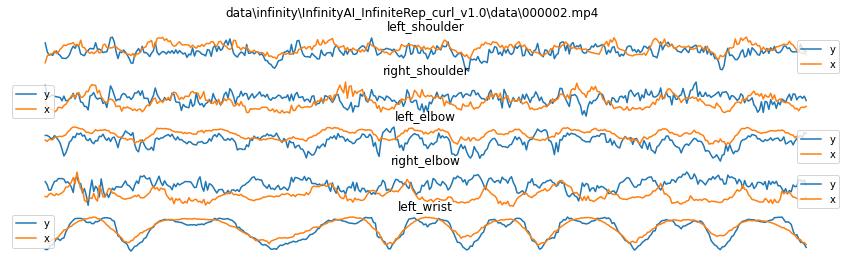

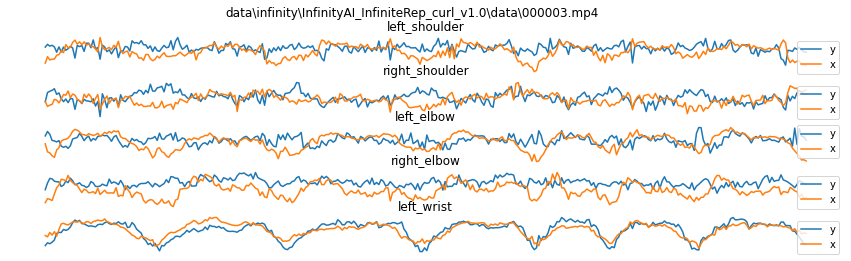

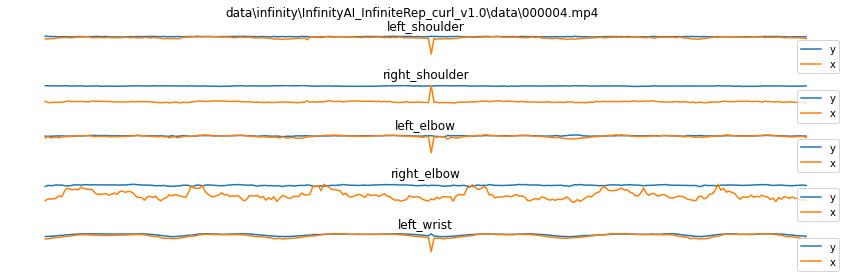

In [15]:
num_kpts = 17
analyze_pathidx = range(95, 105)
analyze_kptsidx = range(5, 10)
num_paths = len(df_kpts.out_keypoints)

for pathidx in analyze_pathidx:
  plt.figure(figsize=(15, 4))
  plt.suptitle(df_kpts.loc[pathidx, 'path'])
    
  for subi, i in enumerate(analyze_kptsidx):
    plt.subplot(5, 1, subi+1)
    plt.plot(np.arange(len(df_kpts.out_keypoints[pathidx])), df_kpts.out_keypoints[pathidx][:,i,0] / np.max(df_kpts.out_keypoints[pathidx][:,i,0]))
    plt.plot(np.arange(len(df_kpts.out_keypoints[pathidx])), df_kpts.out_keypoints[pathidx][:,i,1] / np.max(df_kpts.out_keypoints[pathidx][:,i,1]))
    plt.title(f"{list(CONFIG_KEYPOINTS)[i]}")
    plt.axis('off')
    plt.legend(['y', 'x'])
  
plt.subplots_adjust(hspace=1.5)
plt.rcParams.update({'font.size': 10})


In [16]:
df_edge_features["nose-left_eye-end_x"]

0        77.851601
1        77.807053
2         73.95253
3         76.86171
4        77.126671
           ...    
39718    99.462967
39719    97.770912
39720    97.571541
39721    97.020439
39722    96.248032
Name: nose-left_eye-end_x, Length: 39723, dtype: object

In [17]:
df_edge_z = df_edge_features[name_combinations].astype(float).apply(stats.zscore)

Text(0.5, 1.0, 'z-scored edge features')

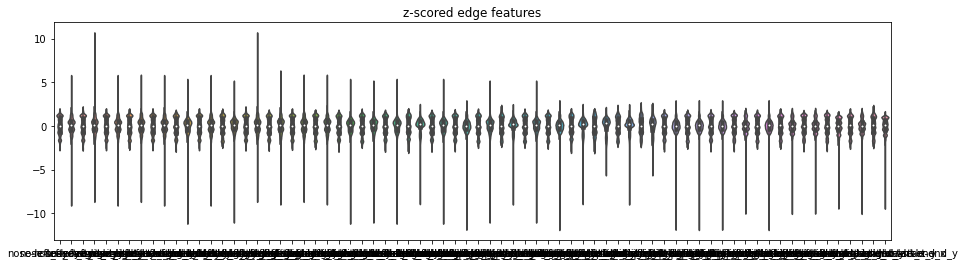

In [18]:
# sanity check
plt.figure(figsize=(15, 4))
ax = sns.violinplot(data=df_edge_z)
plt.title("z-scored edge features")

In [19]:
train_df, test_df = train_test_split(df_edge_z, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# sequence models

## create window generator object for time series

In [20]:
class WindowGenerator():
  '''produces index slices for sliding windows
  label_columns needs to be more than one term or else will do character splitting
  '''
  
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
name_combinations.index('right_elbow-right_wrist-start_x')

48

In [22]:
name_combinations[48]

'right_elbow-right_wrist-start_x'

In [23]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=30,
                      train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['right_elbow-right_wrist-start_x'])

In [24]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
   
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
for example_inputs, example_labels in w1.train.take(3):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 72)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 30, 72)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 30, 72)
Labels shape (batch, time, features): (32, 1, 1)


In [27]:
example_inputs

<tf.Tensor: shape=(32, 30, 72), dtype=float32, numpy=
array([[[-1.8226230e+00, -1.0403796e+00, -1.7790886e+00, ...,
          1.3950194e-01, -1.6167039e+00,  5.0157255e-01],
        [-9.9843830e-02,  9.1596192e-01, -1.1147447e-01, ...,
         -7.3811585e-01,  3.4600928e-02, -8.2904321e-01],
        [-2.5503504e+00, -8.8922615e+00, -2.5875974e+00, ...,
         -9.8494911e+00, -2.3084667e+00, -9.2569990e+00],
        ...,
        [ 1.4327212e-01, -1.1452912e+00,  1.2595463e-01, ...,
          4.3065017e-01, -1.7037617e-01,  7.3961711e-01],
        [ 7.6035005e-01,  4.4320828e-01,  7.7218568e-01, ...,
          1.2601916e+00,  9.1320342e-01,  1.0336884e+00],
        [-9.9564904e-01,  3.8644773e-01, -9.6489084e-01, ...,
          3.6881217e-01, -8.9439583e-01,  2.6236898e-01]],

       [[ 1.3896475e+00,  1.0457818e-01,  1.3459955e+00, ...,
         -4.7529954e-01,  1.1629353e+00, -4.1650292e-01],
        [-3.7093446e-01, -4.2221597e-03, -3.4286416e-01, ...,
          5.7934499e-01, -1.2

In [ ]:
label_index = 48

# baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.optimizers.Adam(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [ ]:
history = compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

In [ ]:
w1.plot(dense, plot_col='right_elbow-right_wrist-start_x')

#### test out LSTM

In [28]:
MAX_EPOCHS = 30

In [29]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, w1)


NameError: name 'compile_and_fit' is not defined

In [ ]:
import IPython
import IPython.display

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

In [ ]:
performance

- extract keypoints
- compute percentage of max
- visualize percentage of max
- AR changepoint analysis?
- split into 10 input --> 1 frame output? 
- simple RNNs using keras

conditional random field ~ extension of logistic regression for sequences, but in nearly all fields NNs have replaced this for sequence models


#### test out keras tuner

In [ ]:
import keras_tuner as kt



set aside for now (unclear keypoint & image ids?)

In [ ]:
import json

# load json files from paths
for path in train_paths[1:2]:
  path_json = path.replace("mp4", "json")
  with open(path_json, 'r') as f:
    data = json.load(f)

  # extract data
  for fri in range(len(data)):
    data['annotations'][fri]['armature_keypoints']
    for kpt in CONFIG_KEYPOINTS.keys():
      data['annotations'][fri]['armature_keypoints'][kpt]


In [ ]:
# load data annotations into dataframe
# data['annotations'][0]['armature_keypoints']

# extract data
kpts_extracted = []
for fri in range(len(data['annotations'])):
  try:
    armkpts = data['annotations'][fri]['armature_keypoints']
    kpts_extracted_fri = []
    for kpt, val in armkpts.items():
      # kpts_extracted_fri.append(val)
      kpts_extracted_fri.append((armkpts[kpt]["x"], armkpts[kpt]["y"]))
      kpts_extracted.append(kpts_extracted_fri)
  except KeyError:
    print(f"KeyError: {kpt} {fri}")

In [ ]:
for i, k in enumerate(CONFIG_KEYPOINTS.keys()):
  print(f"{i} {k}")

In [ ]:
path = train_paths[1]
data_all['out_keypoints'][path].shape

In [ ]:
# vertically concatenate
kpts_extracted = np.concatenate(kpts_extracted)


In [ ]:
kpts_extracted

In [ ]:
kpts_extracted.shape